In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
#tf.enable_eager_execution()
import time
import re
import pickle
#from rouge.rouge import rouge_n_sentence_level


### Loading Data

In [2]:
news = pd.read_csv("C:/Users/91908/Desktop/summary1.csv")

In [3]:
news.head()

,summary,text
0,B said yeah it is that the younger they are th...,A asked have you ever served on a jury? B aske...
1,A said okay some of the things A like to do ar...,A said okay some of the things A like to do ar...
2,B said B think for B from alabama. south alaba...,A asked do you want to give a start on it? B s...
3,last summer B was swim instructor all summer l...,B said B have former exercise program. B am a ...
4,A said all right think our experience of campi...,A said all right think our experience of campi...


In [4]:
news.shape

(754, 2)

In [5]:
document = news['text']
summary = news['summary']

In [6]:
document[0].split()

['A',
 'asked',
 'have',
 'you',
 'ever',
 'served',
 'on',
 'a',
 'jury?',
 'B',
 'asked',
 'no',
 'B',
 'have',
 'not.',
 'B',
 'have',
 'been',
 'called',
 'B',
 'had',
 'to',
 'beg',
 'off',
 'from',
 'the',
 'duty.',
 'you?',
 'A',
 'said',
 'A',
 'was',
 'called',
 'A',
 'was',
 'not',
 'chosen.',
 'B',
 'said',
 'originally',
 'chosen',
 'primarily',
 'B',
 'think',
 'because',
 'B',
 'was',
 'a',
 'young',
 'fellow',
 'they',
 'tend',
 'to',
 'view',
 'the',
 'younger',
 'fellows',
 'as',
 'more',
 'likely',
 'to',
 'hand',
 'down',
 'a',
 'guilty',
 'verdict.',
 'B',
 'do',
 'not',
 'know',
 'why.',
 'something',
 'B',
 'picked',
 'up',
 'in',
 'a',
 'psychology',
 'class',
 'some',
 'time',
 'ago.',
 'A',
 'asked',
 'really?',
 'B',
 'said',
 'yeah',
 'it',
 'is',
 'that',
 'the',
 'younger',
 'they',
 'are',
 'they',
 'tend',
 'to',
 'be',
 'more',
 'conservative',
 'for',
 'some',
 'statistical',
 'oddball',
 'reason',
 'they',
 'kind',
 'of',
 'liked',
 'me.',
 'B',
 'look

### Preprocessing

In [7]:
# for decoder sequence
summary = summary.apply(lambda x: '<go> ' + x + ' <stop>')
summary.head()

0    <go> B said yeah it is that the younger they a...
1    <go> A said okay some of the things A like to ...
2    <go> B said B think for B from alabama. south ...
3    <go> last summer B was swim instructor all sum...
4    <go> A said all right think our experience of ...
Name: summary, dtype: object

In [8]:
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

#### Tokenizing the texts into integer tokens

In [9]:
# since < and > from default tokens cannot be removed
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

In [10]:
document_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

In [11]:
document_tokenizer.fit_on_texts(document)
summary_tokenizer.fit_on_texts(summary)

In [12]:
inputs = document_tokenizer.texts_to_sequences(document)
targets = summary_tokenizer.texts_to_sequences(summary)

In [13]:
sum([len(i) for i in targets])/len(targets)

462.9575596816976

In [14]:
summary_tokenizer.texts_to_sequences(["This is a test"])

[[55, 8, 2, 978]]

In [15]:
summary_tokenizer.sequences_to_texts([[184, 22, 46, 71]])

['okay just them will']

In [16]:
encoder_vocab_size = len(document_tokenizer.word_index) + 1
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(17981, 12135)

#### Obtaining insights on lengths for defining maxlen

In [17]:
document_lengths = pd.Series([len(x.split()) for x in document])
summary_lengths = pd.Series([len(x.split()) for x in summary])

In [18]:
document_lengths.describe()

count     754.000000
mean     1080.667109
std       376.596493
min       455.000000
25%       787.000000
50%       956.000000
75%      1344.750000
max      2310.000000
dtype: float64

In [19]:
summary_lengths.describe()

count     754.000000
mean      464.393899
std       200.763648
min       155.000000
25%       325.000000
50%       410.000000
75%       578.750000
max      1156.000000
dtype: float64

In [20]:
# maxlen
# taking values > and round figured to 75th percentile
# at the same time not leaving high variance
encoder_maxlen = 900
decoder_maxlen = 400

#### Padding/Truncating sequences for identical sequence lengths
Padding can also be applied to the end of the sequences, which may be more appropriate for some problem domains.
Post-sequence padding can be specified

In [21]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

### Creating dataset pipeline

In [22]:
inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

In [23]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

With the help of tf.data.Dataset.from_tensor_slices() method, we can get the slices of an array in the form of objects by using tf.data.Dataset.from_tensor_slices() method.

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Positional Encoding for adding notion of position among words as unlike RNN the Transformer architecture ditched the recurrence mechanism in favor of

- Since no order of flow for each word of the sentence so the model adds positional encoding
- D dimensional vector that contains info about the specific position in a sentence and is used to equip each word with information about its position in a sentence and not the model itselfNN this is non-directional


In [25]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [26]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


- Padding mask for masking "pad" sequences.

- Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.


In [27]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

- The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

- This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [28]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

### Building the Model

#### Scaled Dot Product

In [29]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### Multi-Headed Attention

In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

### Feed Forward Network

In [31]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

#### Fundamental Unit of Transformer encoder
- The encoder is composed of a stack of N = 6 identical layers. Each layer has two sub-layers. 
- The first is a multi-head self-attention mechanism, and the second is a simple, positionwise fully connected feed-forward network. We employ a residual connection around each of the two sub-layers, followed by layer normalization. That is, the output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. 
- To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension dmodel = 512.

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


#### Fundamental Unit of Transformer decoder
- The decoder is also composed of a stack of N = 6 identical layers. In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack.
- Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization. 
- We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. 
- This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.

In [33]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


#### Encoder consisting of multiple EncoderLayer(s)

In [34]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x


#### Decoder consisting of multiple DecoderLayer(s)

In [35]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights


#### Finally, the Transformer

In [36]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


### Training

In [37]:
# hyper-params
num_layers = 2
d_model = 128
dff = 512
num_heads = 8
EPOCHS = 400

#### Adam optimizer with custom learning rate scheduling

In [38]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


#### Defining losses and other metrics 

In [39]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [40]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [41]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


In [42]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

#### Transformer

In [43]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=encoder_vocab_size, 
    pe_target=decoder_vocab_size,
)

#### Masks

In [44]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask


#### Checkpoints

In [45]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


#### Training steps

In [46]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.1093
Epoch 1 Batch 1 Loss 1.1414
Epoch 1 Batch 2 Loss 1.1498
Epoch 1 Batch 3 Loss 1.1622
Epoch 1 Batch 4 Loss 1.1729
Epoch 1 Batch 5 Loss 1.1839
Epoch 1 Batch 6 Loss 1.1804
Epoch 1 Batch 7 Loss 1.1787
Epoch 1 Batch 8 Loss 1.1776
Epoch 1 Batch 9 Loss 1.1815
Epoch 1 Batch 10 Loss 1.1787
Epoch 1 Batch 11 Loss 1.1846
Epoch 1 Loss 1.1846
Time taken for 1 epoch: 321.42355728149414 secs

Epoch 2 Batch 0 Loss 1.1232
Epoch 2 Batch 1 Loss 1.1511
Epoch 2 Batch 2 Loss 1.1503
Epoch 2 Batch 3 Loss 1.1424
Epoch 2 Batch 4 Loss 1.1492
Epoch 2 Batch 5 Loss 1.1523
Epoch 2 Batch 6 Loss 1.1558
Epoch 2 Batch 7 Loss 1.1572
Epoch 2 Batch 8 Loss 1.1609
Epoch 2 Batch 9 Loss 1.1683
Epoch 2 Batch 10 Loss 1.1732
Epoch 2 Batch 11 Loss 1.1736
Epoch 2 Loss 1.1736
Time taken for 1 epoch: 271.64083552360535 secs

Epoch 3 Batch 0 Loss 1.0792
Epoch 3 Batch 1 Loss 1.1007
Epoch 3 Batch 2 Loss 1.1079
Epoch 3 Batch 3 Loss 1.1254
Epoch 3 Batch 4 Loss 1.1262
Epoch 3 Batch 5 Loss 1.1377
Epoch 3 Batch 6 Lo

### Inference

#### Predicting one word at a time at the decoder and appending it to the output; then taking the complete sequence as an input to the decoder and repeating until maxlen or stop keyword appears

In [53]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index["<go>"]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(decoder_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["<stop>"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


In [54]:
def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # not printing <go> token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [56]:
f=open("C:/Users/91908/Desktop/Mini Project/Test Data/text/test1.txt","r")
i=f.read()
fs=summarize(i)
fs

[72]
tf.Tensor([[72]], shape=(1, 1), dtype=int32)


'a asked there a lot of places to camping in dallas area we have one of b said not done some of camping in the best way to camping in the lawn and arkansas b said that b have done camping in the last september just had b enjoy camping when b room and garden and weeds b lived in the lake b did not had had b have done camping b said it is really beautiful beautiful b said it is really had had had had to grow b said that when b have done a said that sounds fun b have done a lot of places b said we have done ours a have done camping twice b said wow a really kind of camping grounds where you have done this country it was there and stuff a have never had a lot more fun to go out a lot of doing camping grounds where you got r v beside you and then another people in tents beside you a just do not care of places b said no a have done camping b said no a said no a said no a said that nature a said no a said that people who did not care of a said no always kills us see that a grill seen this old

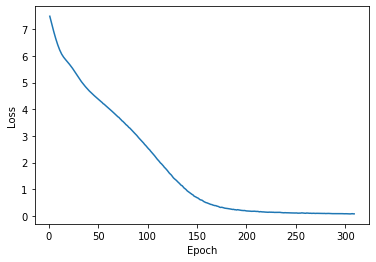

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
data_plot = pd.DataFrame({"Epoch":epoch, "Loss":loss})
 
sns.lineplot(x = "Epoch", y = "Loss", data=data_plot)
plt.show()